# Compare runs, choose a model and deploy it to a REST API

- Run hyperparameter sweap on a traning script
- comapre the results of the runs in the MLflow UI
- choose the best run and register it as a model
- deploy the model to a REST API
- build a container image suitable for deployment to a cloud platform

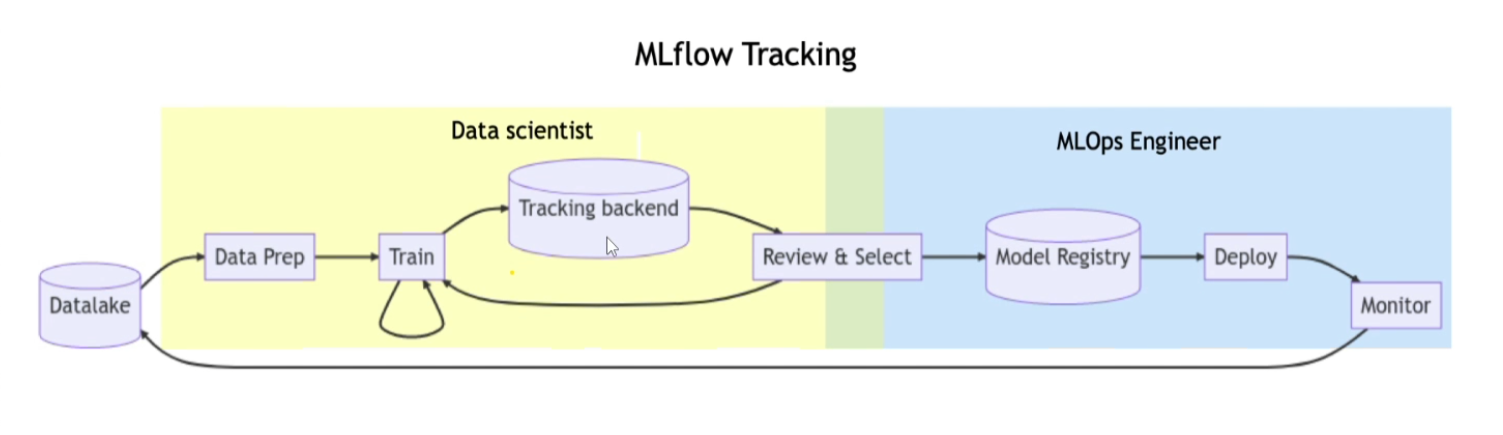

In [23]:
import keras
import numpy as np
import pandas as pd 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature

In [24]:
## load the dataset 
data=pd.read_csv('https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv',sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [25]:
# split the data into training and validation and test set 
train,test=train_test_split(data,test_size=0.25,random_state=42)

In [26]:
trainx=train.drop(columns=['quality'],axis=1).values
trainy=train['quality'].values.ravel()

#test dataset 
testx=test.drop(columns=['quality'],axis=1).values
testy=test['quality'].values.ravel()

#splitting this data into train and validation 
trainx,validx,trainy,validy=train_test_split(trainx,trainy,test_size=0.20,random_state=42)

signature=infer_signature(trainx,trainy)

In [27]:
## ANN model 

def train_model(params, epochs,trainx,trainy,validx,validy,testx,testy):

    ##define the model architecture 
    mean=np.mean(trainx,axis=0)
    var=np.var(trainx,axis=0)

    model=keras.Sequential([
        keras.Input([trainx.shape[1]]),
        keras.layers.Normalization(mean=mean,variance=var),
        keras.layers.Dense(64,activation='relu'),
        keras.layers.Dense(1)
    ])

    ## compile the model
    model.compile(optimizer=keras.optimizers.SGD(
                    learning_rate=params["lr"], momentum=params['momentum']
                                                ),
                 loss='mean_squared_error', 
                 metrics=[keras.metrics.RootMeanSquaredError()]
                  )

    ## Train the ANN model with lr params and momentum param with MLFLow tracking 
    with mlflow.start_run(nested=True):
        model.fit(trainx,trainy,validation_data=(validx,validy),
                  epochs=epochs,
                  batch_size=64
                  )
        
        ## Evalute the model
        eval_result=model.evaluate(validx,validy,batch_size=64)
        eval_rmse=eval_result[1]

        ## log the parameters and results 
        mlflow.log_params(params)
        mlflow.log_metric('eval_rmse',eval_rmse)
        
        ## logging the model
        mlflow.tensorflow.log_model(model,'model',signature=signature)

        return {'loss':eval_rmse,'status':STATUS_OK,'model':model}



In [28]:
## create a hyperopt objective function 
def objective(params):
    result=train_model(
        params,
        epochs=3,
        trainx=trainx,
        trainy=trainy,
        validx=validx,
        validy=validy,
        testx=testx,
        testy=testy
    )
    return result

In [29]:
space={
    "lr":hp.loguniform("lr",np.log(1e-5),np.log(1e-1)),
    'momentum':hp.uniform('momentum',0.0,1.0)
}

In [30]:
mlflow.set_experiment('wine-quality')
with mlflow.start_run():
    # conduct the hyperparameter serach using Hyperopt 
    trials=Trials()
    best=fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=4,
        trials=trials
    )

    # fetch the details of the best run 
    best_run=sorted(trials.results, key=lambda x: x['loss'])[0]

    #Log the best parameters, loss, and models 
    mlflow.log_params(best)
    mlflow.log_metric('eval_rmse',best_run['loss'])
    mlflow.tensorflow.log_model(best_run['model'],'best_model',signature=signature)

    # print out the best parameters and corresponding loss 
    print(f'Best parameters: {best}')
    print(f'Best eval rmse: {best_run['loss']}')


2024/12/23 06:33:53 INFO mlflow.tracking.fluent: Experiment with name 'wine-quality' does not exist. Creating a new experiment.


Epoch 1/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - loss: 33.6452 - root_mean_squared_error: 5.8005
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0619 - root_mean_squared_error: 4.1670 - val_loss: 3.4339 - val_root_mean_squared_error: 1.8531

Epoch 2/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.5866 - root_mean_squared_error: 1.8938
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8371 - root_mean_squared_error: 1.6763 - val_loss: 1.1341 - val_root_mean_squared_error: 1.0649

Epoch 3/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8201 - root_mean_squared_error: 0.9056
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0219 - root_mean_squared_error: 1.0104 - val_loss: 0.8984 - val_root_mean_squared_error: 0.9479

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8178 - root_mean_squared_error: 0.9043
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

In [31]:
### Inferencing 

from mlflow.models import validate_serving_input

model_uri = 'runs:/033ac57c2c7845b3a7bae11bc7509141/model'

# The logged model does not contain an input_example.
# Manually generate a serving payload to verify your model prior to deployment.
from mlflow.models import convert_input_example_to_serving_input

# Define INPUT_EXAMPLE via assignment with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
serving_payload = convert_input_example_to_serving_input(testx)

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

d:\anaconda\envs\mlops\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[5.9892883],
       [6.8887553],
       [6.6186557],
       ...,
       [6.309009 ],
       [6.892956 ],
       [6.017894 ]], dtype=float32)

In [32]:
## method 2 inferencing 
loaded_model=mlflow.pyfunc.load_model(model_uri)

# predict on a pandas dataframe 
import pandas as pd
loaded_model.predict(pd.DataFrame(testx))

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[5.9892883],
       [6.8887553],
       [6.6186557],
       ...,
       [6.309009 ],
       [6.892956 ],
       [6.017894 ]], dtype=float32)

In [33]:
# register in the model registry 

mlflow.register_model(model_uri,'wine-quality')

Successfully registered model 'wine-quality'.
Created version '1' of model 'wine-quality'.


<ModelVersion: aliases=[], creation_timestamp=1734958652797, current_stage='None', description=None, last_updated_timestamp=1734958652797, name='wine-quality', run_id='033ac57c2c7845b3a7bae11bc7509141', run_link=None, source='file:///d:/pythonProjects/MLOps_Krish_Naik/MLflow/MLproject/Deep_Learning/mlruns/999373360568009119/033ac57c2c7845b3a7bae11bc7509141/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>